# 深度卷积GAN

该代码选取CIFAR图像中马的图像学习了一个深度卷积GAN模型，用来生成马的图像。

In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
print("TensorFlow Version: {}".format(tf.__version__))

TensorFlow Version: 1.0.1


# 加载数据

In [3]:
# 加载数据
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    加载单批量的数据
    
    参数：
    cifar10_dataset_folder_path: 数据存储目录
    batch_id: 指定batch的编号
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    # features and labels
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [4]:
# 1.本地路径
#cifar10_path = '/Users/Nelson/Desktop/Computer/courses/cifar-10-batches-py' # 本地路径

# 2.如果使用floyd的GPU，在提交任务时记得加入参数 --data diSgciLH4WA7HpcHNasP9j
import tarfile
cifar10_path = 'cifar-10-batches-py'
tar_gz_path = '/input/cifar-10/python.tar.gz' # 这是floyd上存储CIFAR数据的地址
with tarfile.open(tar_gz_path) as tar:
    tar.extractall()
    tar.close()

# 共有5个batch的训练数据
x_train, y_train = load_cfar10_batch(cifar10_path, 1)
for i in range(2, 6):
    features, labels = load_cfar10_batch(cifar10_path, i)
    x_train, y_train = np.concatenate([x_train, features]), np.concatenate([y_train, labels])

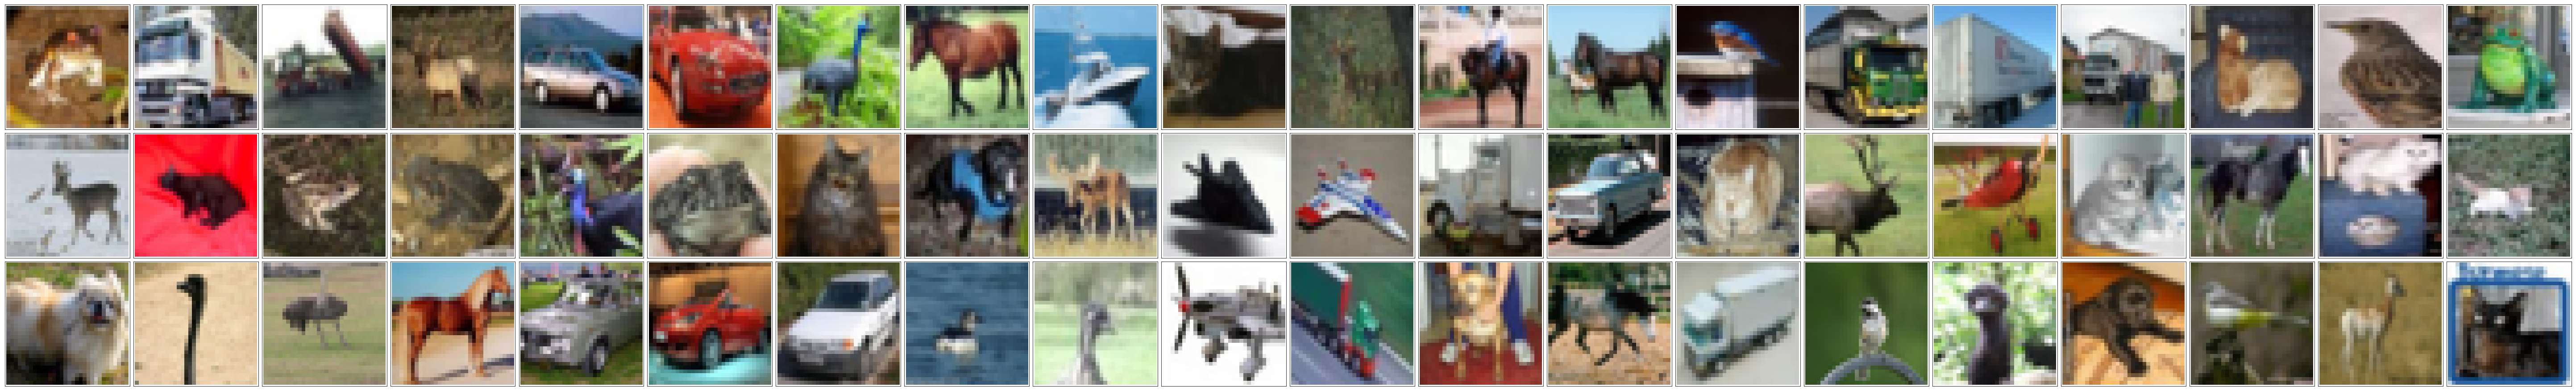

In [6]:
# 显示图片
fig, axes = plt.subplots(nrows=3, ncols=20, sharex=True, sharey=True, figsize=(80,12))
imgs = x_train[:60]

for image, row in zip([imgs[:20], imgs[20:40], imgs[40:60]], axes):
    for img, ax in zip(image, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

# 数据归一化

In [13]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

# 重塑
x_train_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3)

# 归一化
x_train = minmax.fit_transform(x_train_rows)

In [14]:
# 重新变为32 x 32 x 3
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)

In [15]:
# 选出马的图像
images = x_train[y_train==7]

# 构建模型

- inputs
- generator
- discriminator
- loss
- optimizer
- train

## Inputs

In [16]:
def get_inputs(noise_dim, image_height, image_width, image_depth):
    """
    @Author: Nelson Zhao
    --------------------
    :param noise_dim: 噪声图片的size
    :param image_height: 真实图像的height
    :param image_width: 真实图像的width
    :param image_depth: 真实图像的depth
    """ 
    inputs_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth], name='inputs_real')
    inputs_noise = tf.placeholder(tf.float32, [None, noise_dim], name='inputs_noise')
    
    return inputs_real, inputs_noise

# Generator

In [17]:
def get_generator(noise_img, output_dim, is_train=True, alpha=0.01):
    """
    @Author: Nelson Zhao
    --------------------
    :param noise_img: 噪声信号，tensor类型
    :param output_dim: 生成图片的depth
    :param is_train: 是否为训练状态，该参数主要用于作为batch_normalization方法中的参数使用
    :param alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        # 100 x 1 to 4 x 4 x 512
        # 全连接层
        layer1 = tf.layers.dense(noise_img, 4*4*512)
        layer1 = tf.reshape(layer1, [-1, 4, 4, 512])
        # batch normalization
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        # Leaky ReLU
        layer1 = tf.maximum(alpha * layer1, layer1)
        # dropout
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 4 x 4 x 512 to 8 x 8 x 256
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 4, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 8 x 8 256 to 16 x 16 x 128
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 16 x 16 x 128 to 32 x 32 x 3
        logits = tf.layers.conv2d_transpose(layer3, output_dim, 3, strides=2, padding='same')
        # MNIST原始数据集的像素范围在0-1，这里的生成图片范围为(-1,1)
        # 因此在训练时，记住要把MNIST像素范围进行resize
        outputs = tf.tanh(logits)
        
        return outputs

## Discriminator

In [18]:
def get_discriminator(inputs_img, reuse=False, alpha=0.01):
    """
    @Author: Nelson Zhao
    --------------------
    @param inputs_img: 输入图片，tensor类型
    @param alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # 32 x 32 x 3 to 16 x 16 x 128
        # 第一层不加入BN
        layer1 = tf.layers.conv2d(inputs_img, 128, 3, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 16 x 16 x 128 to 8 x 8 x 256
        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 8 x 8 x 256 to 4 x 4 x 512
        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 4 x 4 x 512 to 4*4*512 x 1
        flatten = tf.reshape(layer3, (-1, 4*4*512))
        logits = tf.layers.dense(flatten, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

## Loss

In [19]:
def get_loss(inputs_real, inputs_noise, image_depth, smooth=0.1):
    """
    @Author: Nelson Zhao
    --------------------
    @param inputs_real: 输入图片，tensor类型
    @param inputs_noise: 噪声图片，tensor类型
    @param image_depth: 图片的depth（或者叫channel）
    @param smooth: label smoothing的参数
    """
    
    g_outputs = get_generator(inputs_noise, image_depth, is_train=True)
    d_logits_real, d_outputs_real = get_discriminator(inputs_real)
    d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, reuse=True)
    
    # 计算Loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_outputs_fake)*(1-smooth)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_outputs_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_outputs_fake)))
    d_loss = tf.add(d_loss_real, d_loss_fake)
    
    return g_loss, d_loss

## Optimizer

In [20]:
def get_optimizer(g_loss, d_loss, beta1=0.4, learning_rate=0.001):
    """
    @Author: Nelson Zhao
    --------------------
    @param g_loss: Generator的Loss
    @param d_loss: Discriminator的Loss
    @learning_rate: 学习率
    """
    
    train_vars = tf.trainable_variables()
    
    g_vars = [var for var in train_vars if var.name.startswith("generator")]
    d_vars = [var for var in train_vars if var.name.startswith("discriminator")]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return g_opt, d_opt

## 辅助函数，用来在迭代中显示图片

In [21]:
def plot_images(samples):
    samples = (samples + 1) / 2
    fig, axes = plt.subplots(nrows=1, ncols=15, sharex=True, sharey=True, figsize=(30,2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((32, 32, 3)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [22]:
def show_generator_output(sess, n_images, inputs_noise, output_dim):
    """
    @Author: Nelson Zhao
    --------------------
    @param sess: TensorFlow session
    @param n_images: 展示图片的数量
    @param inputs_noise: 噪声图片
    @param output_dim: 图片的depth（或者叫channel）
    @param image_mode: 图像模式：RGB或者灰度
    """
    cmap = 'Greys_r'
    noise_shape = inputs_noise.get_shape().as_list()[-1]
    # 生成噪声图片
    examples_noise = np.random.uniform(-1, 1, size=[n_images, noise_shape])

    samples = sess.run(get_generator(inputs_noise, output_dim, False),
                       feed_dict={inputs_noise: examples_noise})
    return samples

## Train

In [25]:
# 定义参数
batch_size = 64
noise_size = 100
epochs = 50
n_samples = 15
learning_rate = 0.001
beta1 = 0.4

In [26]:
def train(noise_size, data_shape, batch_size, n_samples):
    """
    @Author: Nelson Zhao
    --------------------
    @param noise_size: 噪声size
    @param data_shape: 真实图像shape
    @batch_size:
    @n_samples: 显示示例图片数量
    """
    
    # 存储loss
    losses = []
    steps = 0
    
    inputs_real, inputs_noise = get_inputs(noise_size, data_shape[1], data_shape[2], data_shape[3])
    g_loss, d_loss = get_loss(inputs_real, inputs_noise, data_shape[-1])
    g_train_opt, d_train_opt = get_optimizer(g_loss, d_loss, beta1, learning_rate)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # 迭代epoch
        for e in range(epochs):
            for batch_i in range(images.shape[0]//batch_size-1):
                steps += 1
                batch_images = images[batch_i * batch_size: (batch_i+1)*batch_size]

                # scale to -1, 1
                batch_images = batch_images * 2 - 1

                # noise
                batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))

                # run optimizer
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    train_loss_g = g_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    losses.append((train_loss_d, train_loss_g))
                    # 显示图片
                    samples = show_generator_output(sess, n_samples, inputs_noise, data_shape[-1])
                    plot_images(samples)
                    print("Epoch {}/{}....".format(e+1, epochs), 
                          "Discriminator Loss: {:.4f}....".format(train_loss_d),
                          "Generator Loss: {:.4f}....". format(train_loss_g))
                                   

Epoch 2/50.... Discriminator Loss: 0.7785.... Generator Loss: 1.9247....
Epoch 3/50.... Discriminator Loss: 0.5740.... Generator Loss: 2.9594....
Epoch 4/50.... Discriminator Loss: 0.7521.... Generator Loss: 3.3175....
Epoch 6/50.... Discriminator Loss: 0.7425.... Generator Loss: 1.7179....
Epoch 7/50.... Discriminator Loss: 0.7838.... Generator Loss: 3.3808....
Epoch 8/50.... Discriminator Loss: 0.6287.... Generator Loss: 1.9853....
Epoch 10/50.... Discriminator Loss: 0.7290.... Generator Loss: 2.5281....
Epoch 11/50.... Discriminator Loss: 0.9726.... Generator Loss: 2.7264....
Epoch 12/50.... Discriminator Loss: 0.8714.... Generator Loss: 1.9202....
Epoch 13/50.... Discriminator Loss: 0.8499.... Generator Loss: 1.3660....
Epoch 15/50.... Discriminator Loss: 1.1974.... Generator Loss: 3.7465....
Epoch 16/50.... Discriminator Loss: 0.8458.... Generator Loss: 1.3381....
Epoch 17/50.... Discriminator Loss: 0.7836.... Generator Loss: 1.2296....
Epoch 19/50.... Discriminator Loss: 0.9984..

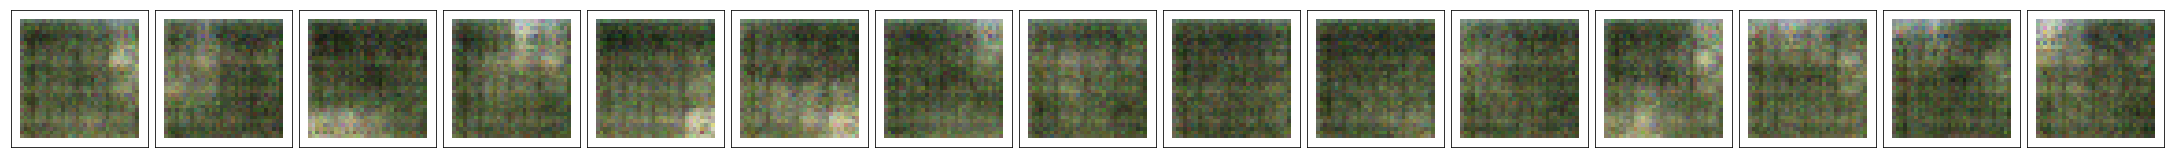

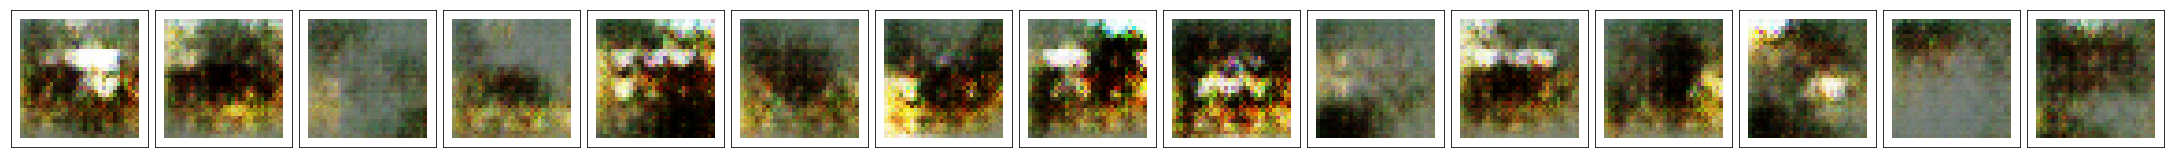

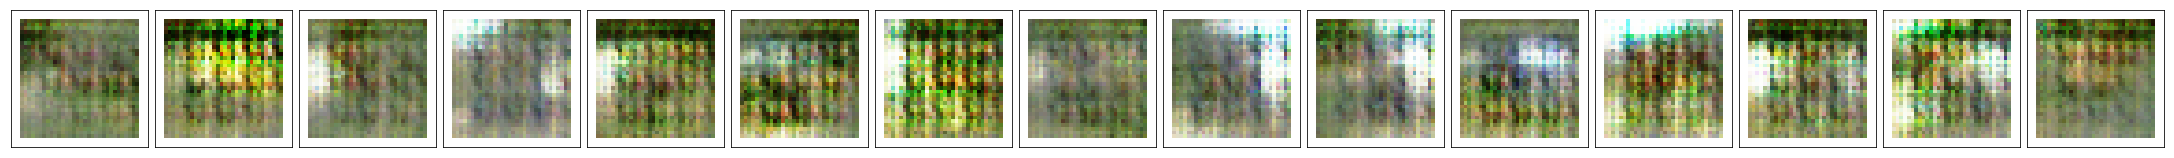

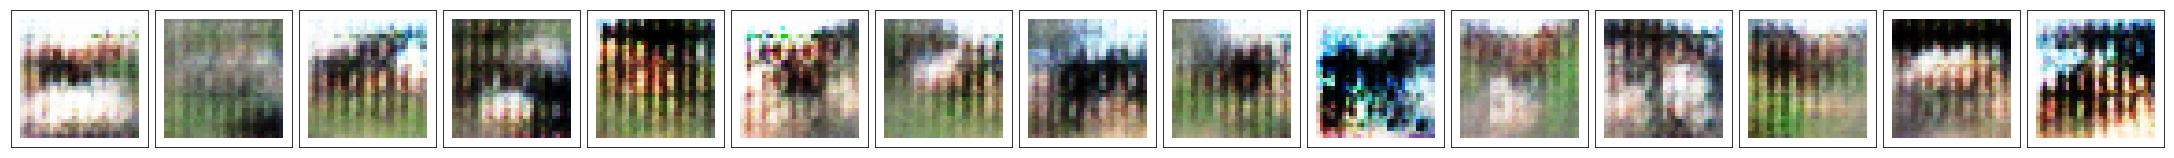

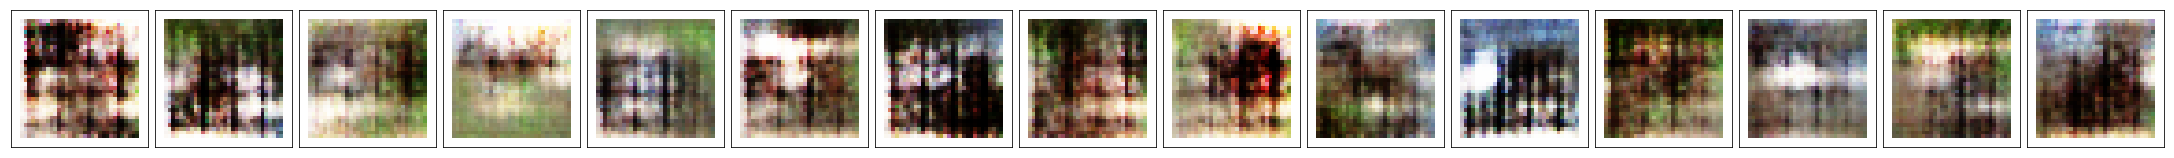

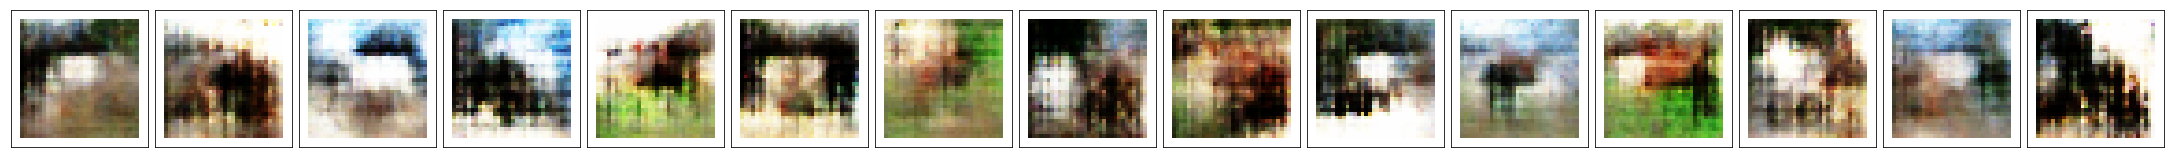

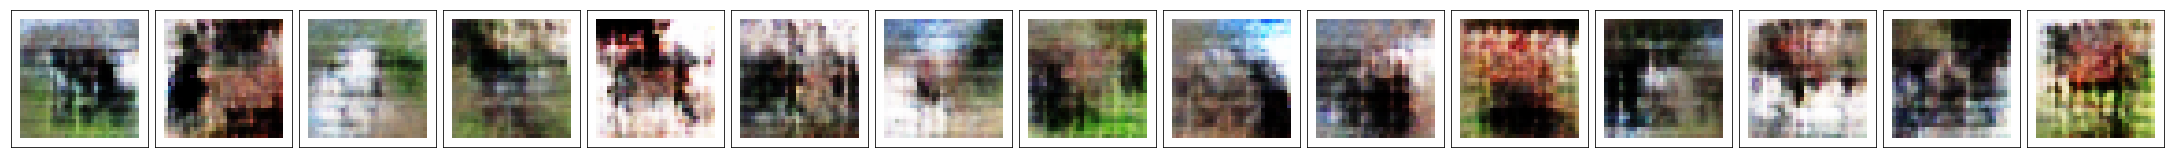

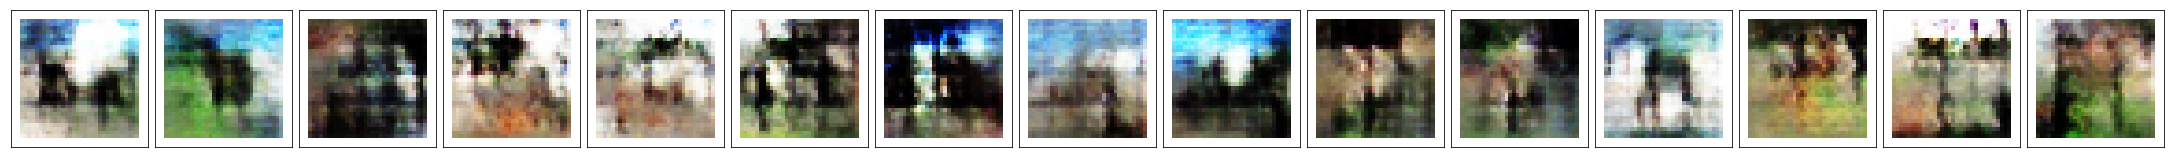

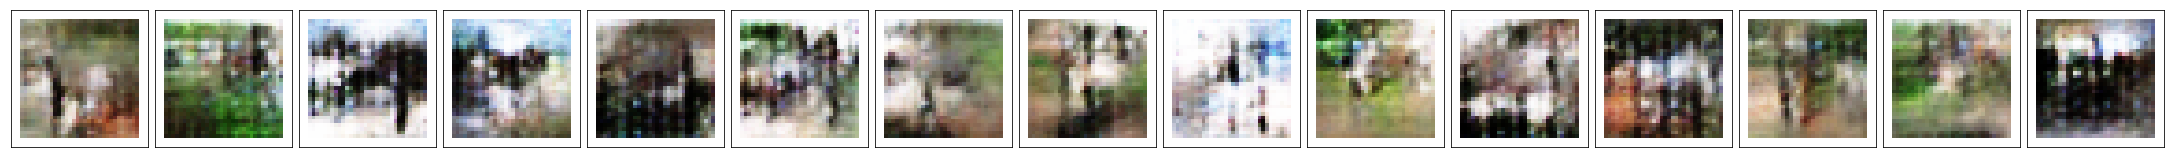

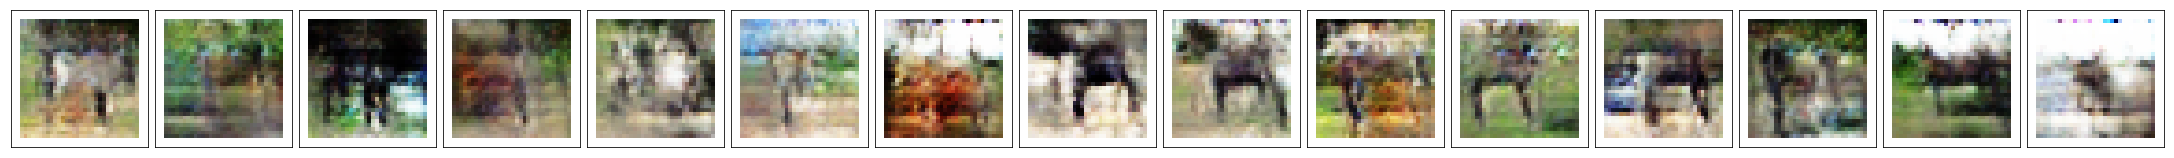

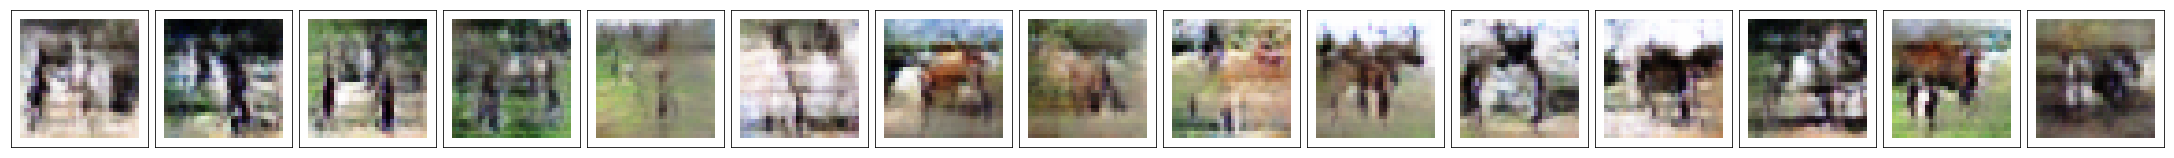

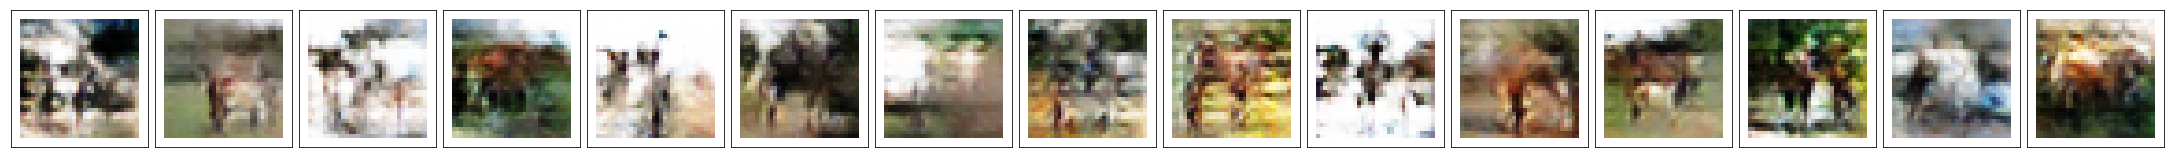

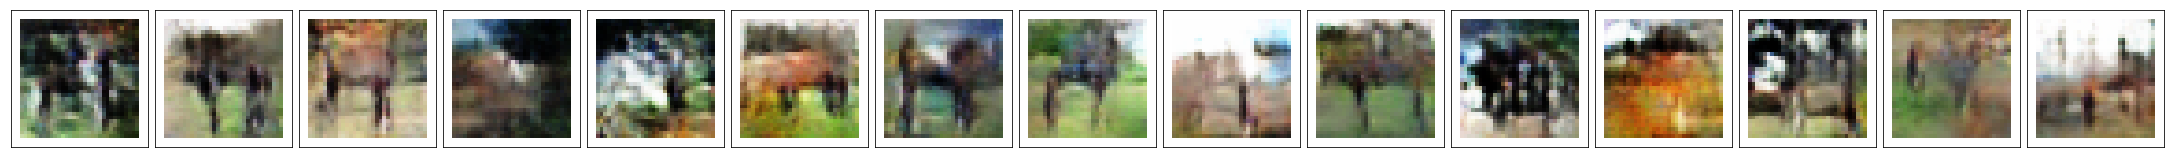

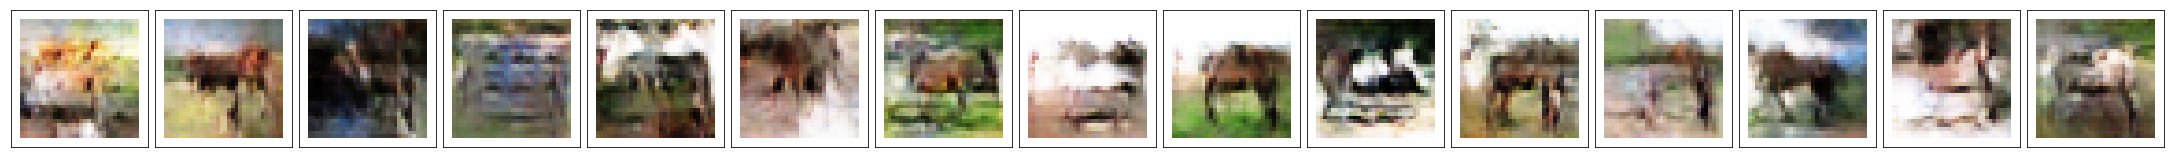

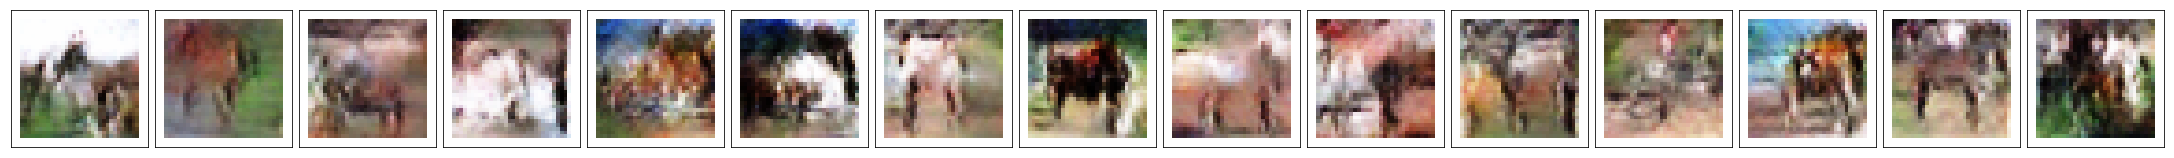

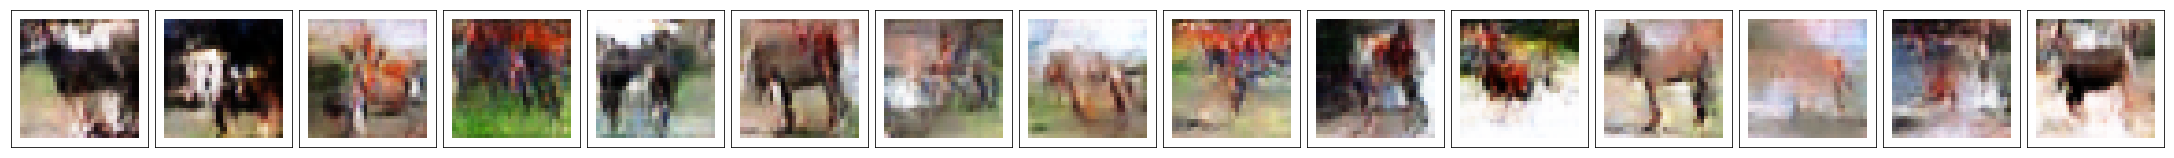

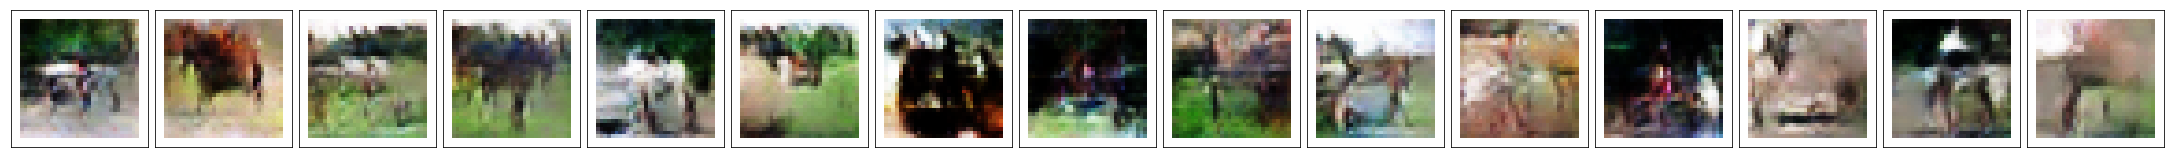

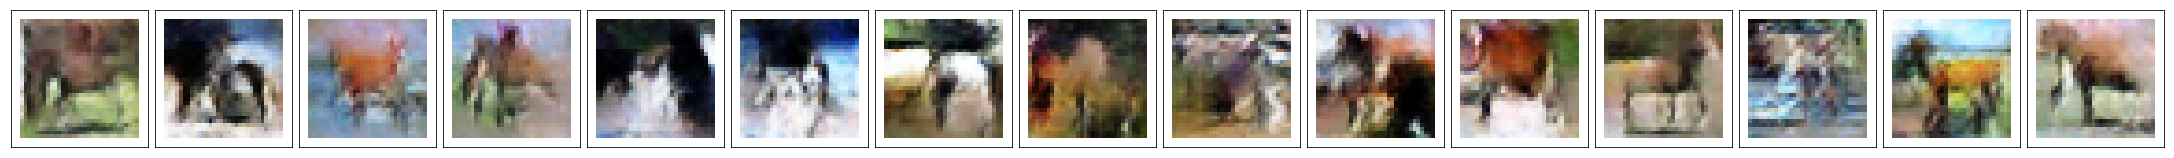

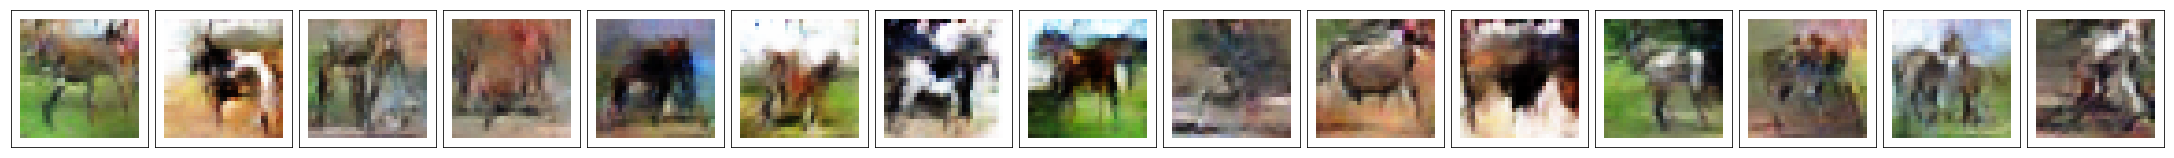

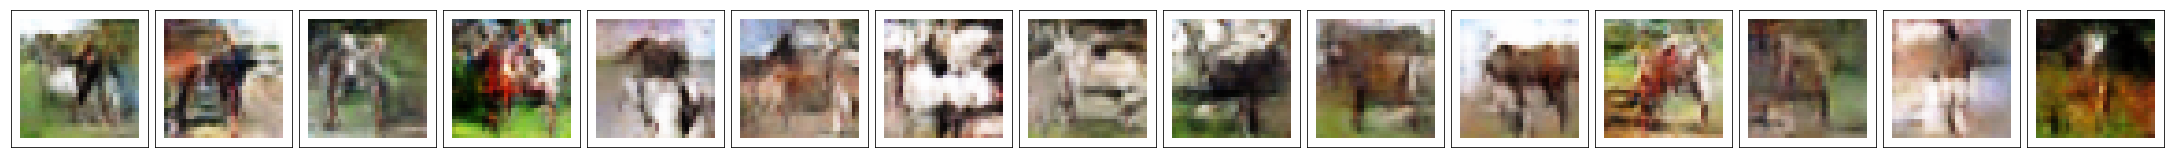

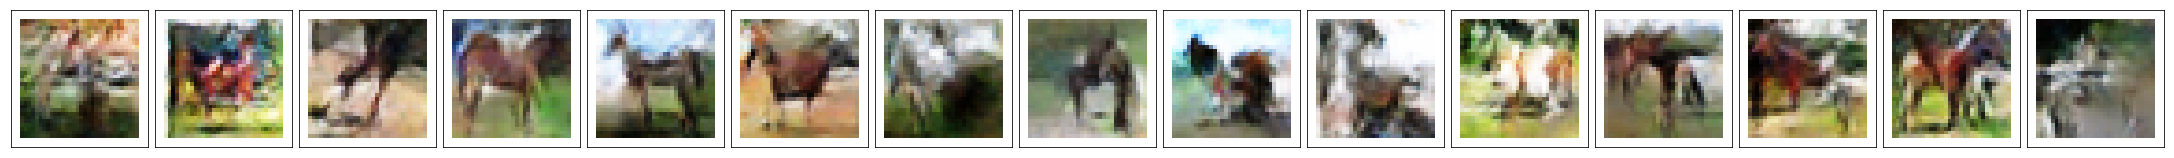

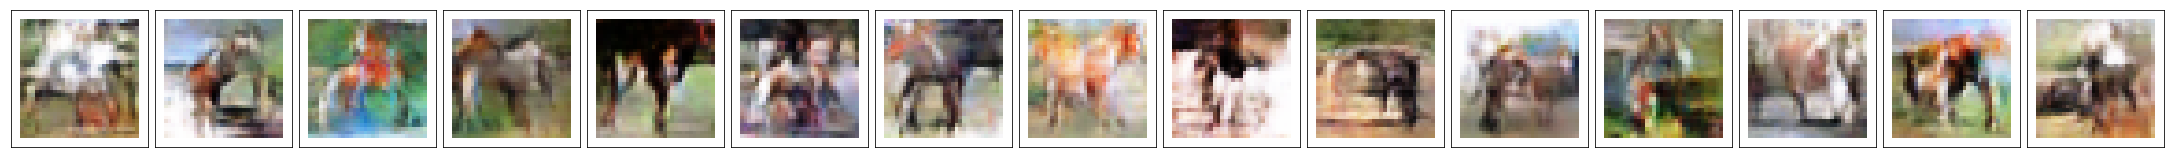

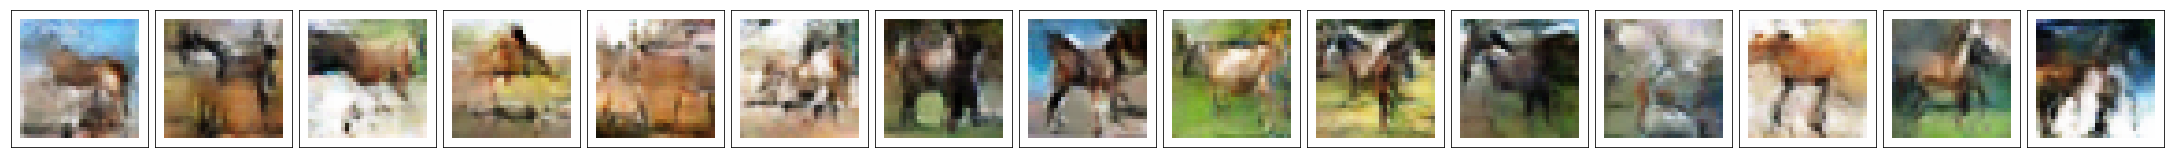

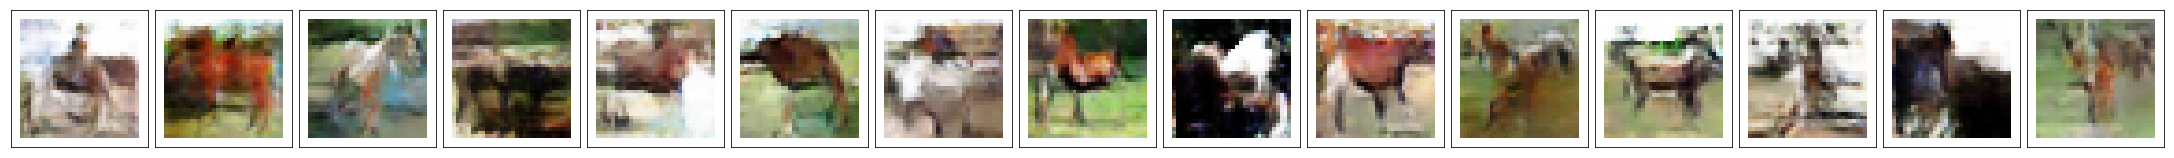

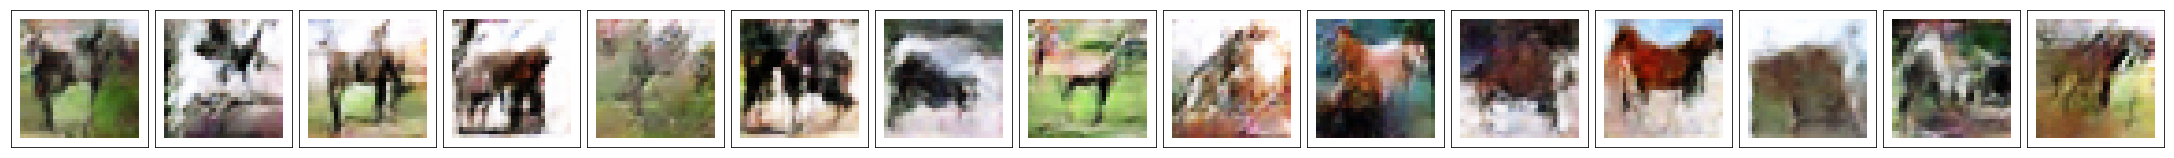

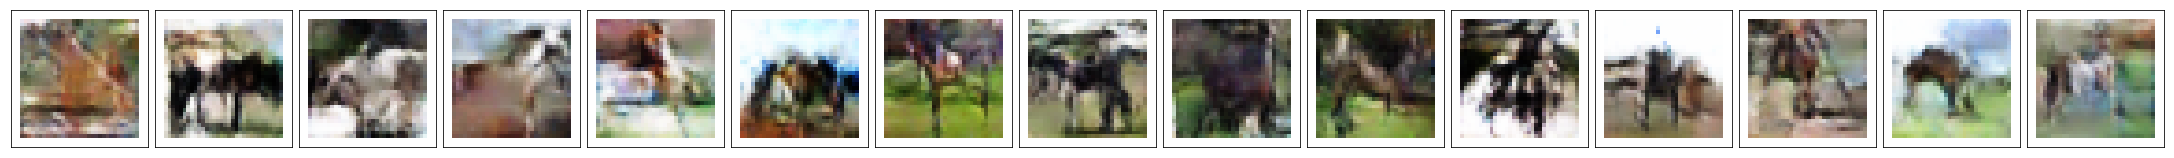

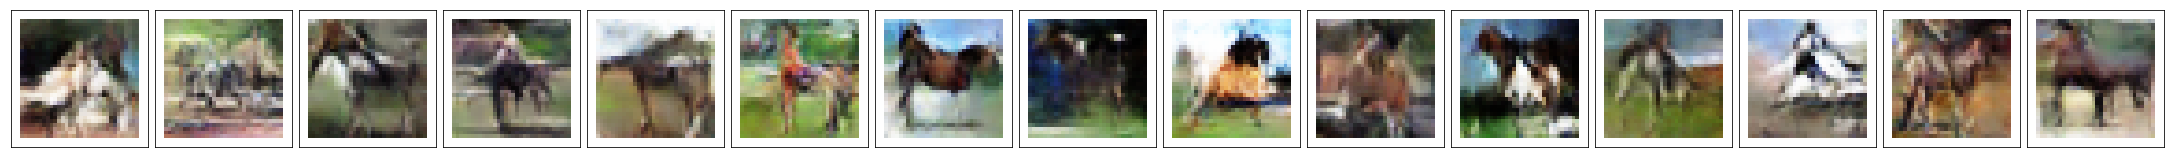

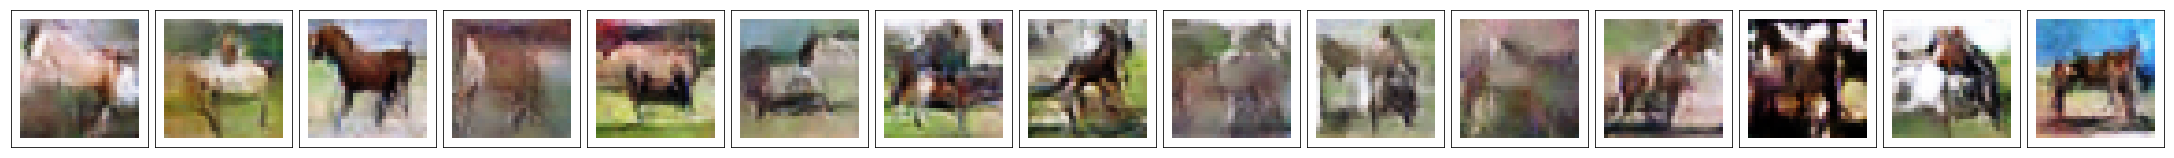

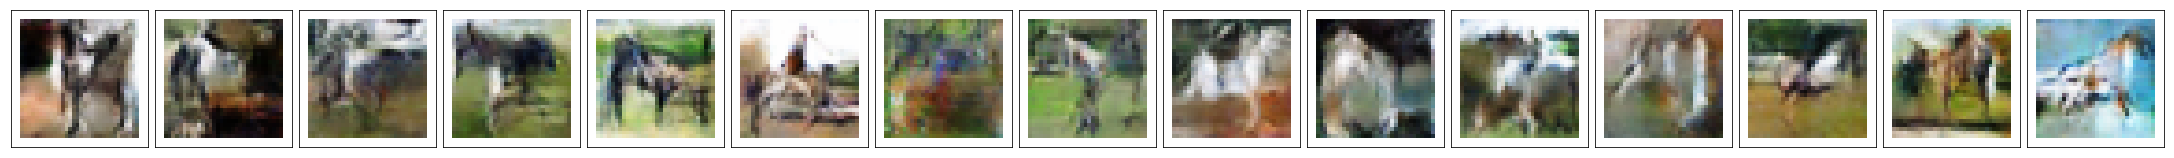

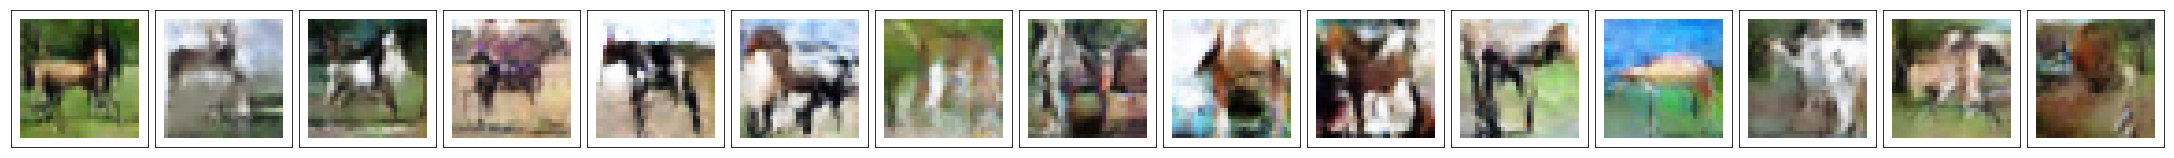

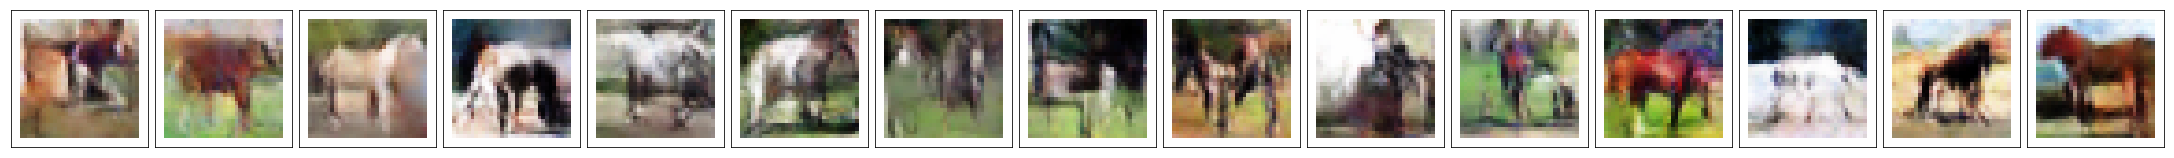

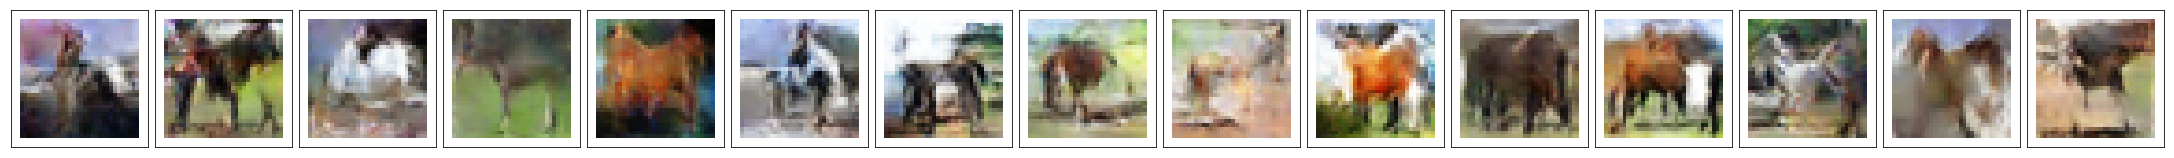

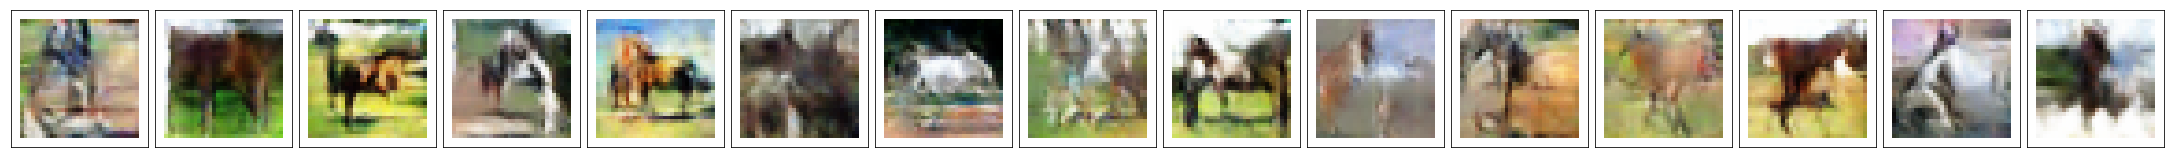

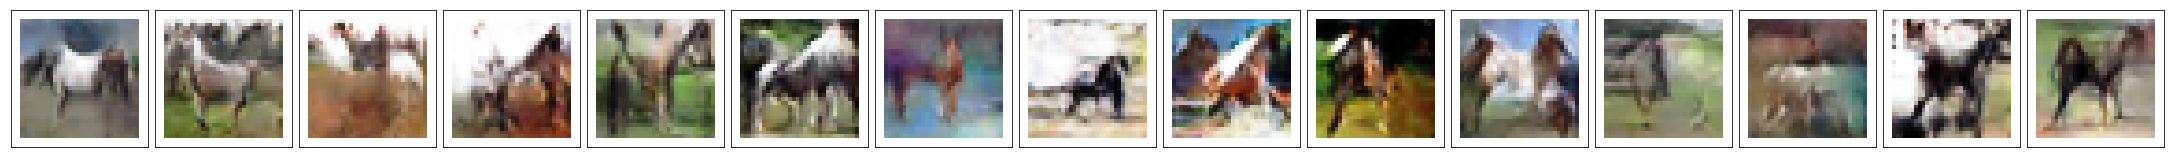

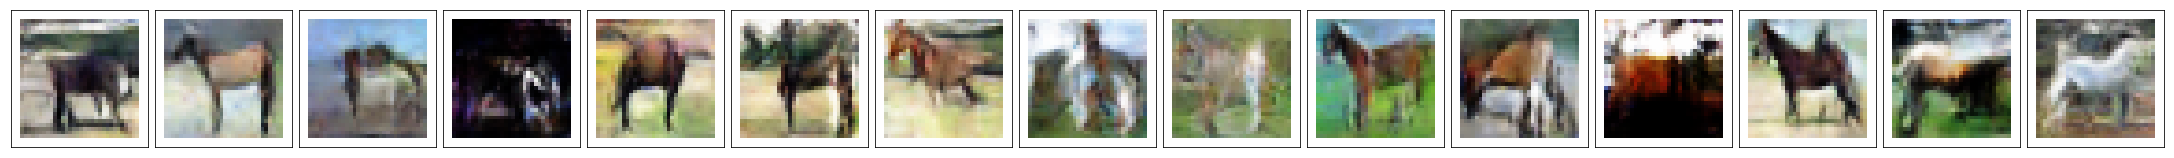

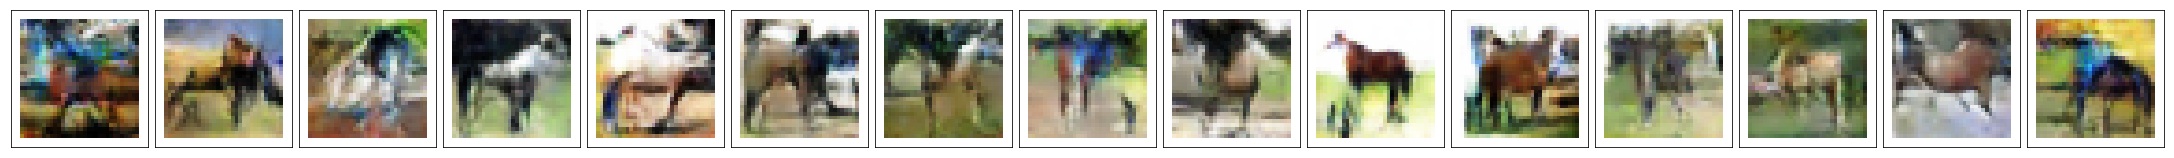

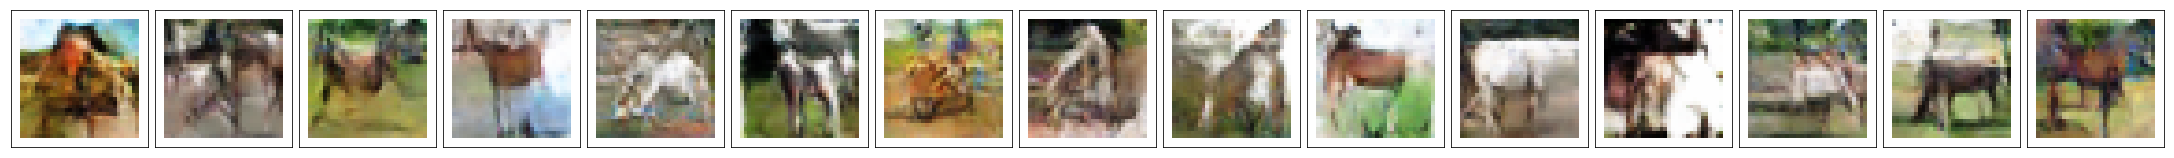

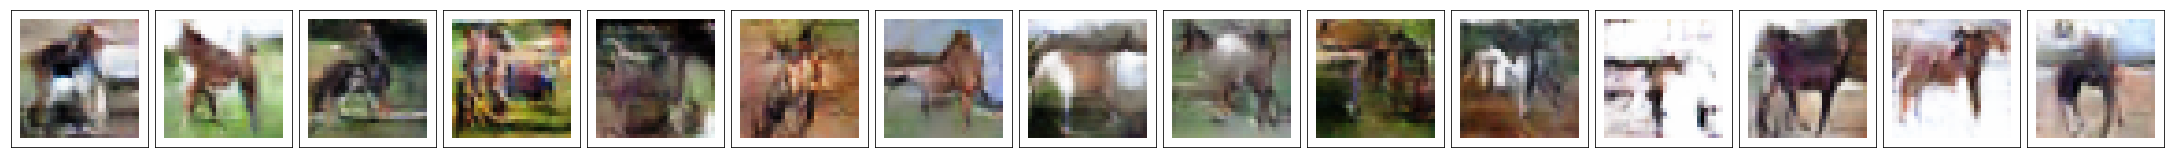

In [27]:
with tf.Graph().as_default():
    train(noise_size, [-1, 32, 32, 3], batch_size, n_samples)